In [1]:
import torch

In [2]:
"""CTGAN module."""

import warnings

import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from tqdm import tqdm

from ctgan.data_sampler import DataSampler
from ctgan.data_transformer import DataTransformer
from ctgan.errors import InvalidDataError
from ctgan.synthesizers.base import BaseSynthesizer, random_state


class Discriminator(Module):
    """Discriminator for the CTGAN."""

    def __init__(self, input_dim, discriminator_dim, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        """Compute the gradient penalty."""
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input_):
        """Apply the Discriminator to the `input_`."""
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim))


class Residual(Module):
    """Residual layer for the CTGAN."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)


class Generator(Module):
    """Generator for the CTGAN."""

    def __init__(self, embedding_dim, generator_dim, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        data = self.seq(input_)
        return data


class CTGAN(BaseSynthesizer):
    """Conditional Table GAN Synthesizer.

    This is the core class of the CTGAN project, where the different components
    are orchestrated together.
    For more details about the process, please check the [Modeling Tabular data using
    Conditional GAN](https://arxiv.org/abs/1907.00503) paper.

    Args:
        embedding_dim (int):
            Size of the random sample passed to the Generator. Defaults to 128.
        generator_dim (tuple or list of ints):
            Size of the output samples for each one of the Residuals. A Residual Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        discriminator_dim (tuple or list of ints):
            Size of the output samples for each one of the Discriminator Layers. A Linear Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        generator_lr (float):
            Learning rate for the generator. Defaults to 2e-4.
        generator_decay (float):
            Generator weight decay for the Adam Optimizer. Defaults to 1e-6.
        discriminator_lr (float):
            Learning rate for the discriminator. Defaults to 2e-4.
        discriminator_decay (float):
            Discriminator weight decay for the Adam Optimizer. Defaults to 1e-6.
        batch_size (int):
            Number of data samples to process in each step.
        discriminator_steps (int):
            Number of discriminator updates to do for each generator update.
            From the WGAN paper: https://arxiv.org/abs/1701.07875. WGAN paper
            default is 5. Default used is 1 to match original CTGAN implementation.
        log_frequency (boolean):
            Whether to use log frequency of categorical levels in conditional
            sampling. Defaults to ``True``.
        verbose (boolean):
            Whether to have print statements for progress results. Defaults to ``False``.
        epochs (int):
            Number of training epochs. Defaults to 300.
        pac (int):
            Number of samples to group together when applying the discriminator.
            Defaults to 10.
        cuda (bool):
            Whether to attempt to use cuda for GPU computation.
            If this is False or CUDA is not available, CPU will be used.
            Defaults to ``True``.
    """

    def __init__(
        self,
        embedding_dim=128,
        generator_dim=(256, 256),
        discriminator_dim=(256, 256),
        generator_lr=2e-4,
        generator_decay=1e-6,
        discriminator_lr=2e-4,
        discriminator_decay=1e-6,
        batch_size=500,
        discriminator_steps=1,
        log_frequency=True,
        verbose=False,
        epochs=300,
        pac=10,
        cuda=True,
    ):
        assert batch_size % 2 == 0

        self._embedding_dim = embedding_dim
        self._generator_dim = generator_dim
        self._discriminator_dim = discriminator_dim

        self._generator_lr = generator_lr
        self._generator_decay = generator_decay
        self._discriminator_lr = discriminator_lr
        self._discriminator_decay = discriminator_decay

        self._batch_size = batch_size
        self._discriminator_steps = discriminator_steps
        self._log_frequency = log_frequency
        self._verbose = verbose
        self._epochs = epochs
        self.pac = pac

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

        self._transformer = None
        self._data_sampler = None
        self._generator = None
        self._discriminator = None
        self.loss_values = None

    @staticmethod
    def _gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
        """Deals with the instability of the gumbel_softmax for older versions of torch.

        For more details about the issue:
        https://drive.google.com/file/d/1AA5wPfZ1kquaRtVruCd6BiYZGcDeNxyP/view?usp=sharing

        Args:
            logits […, num_features]:
                Unnormalized log probabilities
            tau:
                Non-negative scalar temperature
            hard (bool):
                If True, the returned samples will be discretized as one-hot vectors,
                but will be differentiated as if it is the soft sample in autograd
            dim (int):
                A dimension along which softmax will be computed. Default: -1.

        Returns:
            Sampled tensor of same shape as logits from the Gumbel-Softmax distribution.
        """
        for _ in range(10):
            transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
            if not torch.isnan(transformed).any():
                return transformed

        raise ValueError('gumbel_softmax returning NaN.')

    def _apply_activate(self, data):
        """Apply proper activation function to the output of the generator."""
        data_t = []
        st = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if span_info.activation_fn == 'tanh':
                    ed = st + span_info.dim
                    data_t.append(torch.tanh(data[:, st:ed]))
                    st = ed
                elif span_info.activation_fn == 'softmax':
                    ed = st + span_info.dim
                    transformed = self._gumbel_softmax(data[:, st:ed], tau=0.2)
                    data_t.append(transformed)
                    st = ed
                else:
                    raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

        return torch.cat(data_t, dim=1)

    def _cond_loss(self, data, c, m):
        """Compute the cross entropy loss on the fixed discrete column."""
        loss = []
        st = 0
        st_c = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                    # not discrete column
                    st += span_info.dim
                else:
                    ed = st + span_info.dim
                    ed_c = st_c + span_info.dim
                    tmp = functional.cross_entropy(
                        data[:, st:ed], torch.argmax(c[:, st_c:ed_c], dim=1), reduction='none'
                    )
                    loss.append(tmp)
                    st = ed
                    st_c = ed_c

        loss = torch.stack(loss, dim=1)  # noqa: PD013

        return (loss * m).sum() / data.size()[0]

    def _validate_discrete_columns(self, train_data, discrete_columns):
        """Check whether ``discrete_columns`` exists in ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        if isinstance(train_data, pd.DataFrame):
            invalid_columns = set(discrete_columns) - set(train_data.columns)
        elif isinstance(train_data, np.ndarray):
            invalid_columns = []
            for column in discrete_columns:
                if column < 0 or column >= train_data.shape[1]:
                    invalid_columns.append(column)
        else:
            raise TypeError('``train_data`` should be either pd.DataFrame or np.array.')

        if invalid_columns:
            raise ValueError(f'Invalid columns found: {invalid_columns}')

    def _validate_null_data(self, train_data, discrete_columns):
        """Check whether null values exist in continuous ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        if isinstance(train_data, pd.DataFrame):
            continuous_cols = list(set(train_data.columns) - set(discrete_columns))
            any_nulls = train_data[continuous_cols].isna().any().any()
        else:
            continuous_cols = [i for i in range(train_data.shape[1]) if i not in discrete_columns]
            any_nulls = pd.DataFrame(train_data)[continuous_cols].isna().any().any()

        if any_nulls:
            raise InvalidDataError(
                'CTGAN does not support null values in the continuous training data. '
                'Please remove all null values from your continuous training data.'
            )

    @random_state
    def fit(self, train_data, discrete_columns=(), epochs=None):
        """Fit the CTGAN Synthesizer models to the training data.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        self._validate_discrete_columns(train_data, discrete_columns)
        self._validate_null_data(train_data, discrete_columns)

        if epochs is None:
            epochs = self._epochs
        else:
            warnings.warn(
                (
                    '`epochs` argument in `fit` method has been deprecated and will be removed '
                    'in a future version. Please pass `epochs` to the constructor instead'
                ),
                DeprecationWarning,
            )

        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)

        self._data_sampler = DataSampler(
            train_data, self._transformer.output_info_list, self._log_frequency
        )

        data_dim = self._transformer.output_dimensions

        self._generator = Generator(
            self._embedding_dim + self._data_sampler.dim_cond_vec(), self._generator_dim, data_dim
        ).to(self._device)

        discriminator = Discriminator(
            data_dim + self._data_sampler.dim_cond_vec(), self._discriminator_dim, pac=self.pac
        ).to(self._device)

        optimizerG = optim.Adam(
            self._generator.parameters(),
            lr=self._generator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._generator_decay,
        )

        optimizerD = optim.Adam(
            discriminator.parameters(),
            lr=self._discriminator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._discriminator_decay,
        )

        mean = torch.zeros(self._batch_size, self._embedding_dim, device=self._device)
        std = mean + 1

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Distriminator Loss'])

        epoch_iterator = tqdm(range(epochs), disable=(not self._verbose))
        if self._verbose:
            description = 'Gen. ({gen:.2f}) | Discrim. ({dis:.2f})'
            epoch_iterator.set_description(description.format(gen=0, dis=0))

        steps_per_epoch = max(len(train_data) // self._batch_size, 1)
        for i in epoch_iterator:
            for id_ in range(steps_per_epoch):
                for n in range(self._discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std)

                    condvec = self._data_sampler.sample_condvec(self._batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col, opt
                        )
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to(self._device)
                        m1 = torch.from_numpy(m1).to(self._device)
                        fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange(self._batch_size)
                        np.random.shuffle(perm)
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col[perm], opt[perm]
                        )
                        c2 = c1[perm]

                    fake = self._generator(fakez)
                    fakeact = self._apply_activate(fake)

                    real = torch.from_numpy(real.astype('float32')).to(self._device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        real_cat = real
                        fake_cat = fakeact

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat, self._device, self.pac
                    )
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

                    optimizerD.zero_grad(set_to_none=False)
                    pen.backward(retain_graph=True)
                    loss_d.backward()
                    optimizerD.step()

                fakez = torch.normal(mean=mean, std=std)
                condvec = self._data_sampler.sample_condvec(self._batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self._device)
                    m1 = torch.from_numpy(m1).to(self._device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self._generator(fakez)
                fakeact = self._apply_activate(fake)

                if c1 is not None:
                    y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = self._cond_loss(fake, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                optimizerG.zero_grad(set_to_none=False)
                loss_g.backward()
                optimizerG.step()

            generator_loss = loss_g.detach().cpu().item()
            discriminator_loss = loss_d.detach().cpu().item()

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i],
                'Generator Loss': [generator_loss],
                'Discriminator Loss': [discriminator_loss],
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            if self._verbose:
                epoch_iterator.set_description(
                    description.format(gen=generator_loss, dis=discriminator_loss)
                )
        self._discriminator = discriminator

    @random_state
    def sample(self, n, condition_column=None, condition_value=None):
        """Sample data similar to the training data.

        Choosing a condition_column and condition_value will increase the probability of the
        discrete condition_value happening in the condition_column.

        Args:
            n (int):
                Number of rows to sample.
            condition_column (string):
                Name of a discrete column.
            condition_value (string):
                Name of the category in the condition_column which we wish to increase the
                probability of happening.

        Returns:
            numpy.ndarray or pandas.DataFrame
        """
        if condition_column is not None and condition_value is not None:
            condition_info = self._transformer.convert_column_name_value_to_id(
                condition_column, condition_value
            )
            global_condition_vec = self._data_sampler.generate_cond_from_condition_column_info(
                condition_info, self._batch_size
            )
        else:
            global_condition_vec = None

        steps = n // self._batch_size + 1
        data = []
        for i in range(steps):
            mean = torch.zeros(self._batch_size, self._embedding_dim)
            std = mean + 1
            fakez = torch.normal(mean=mean, std=std).to(self._device)

            if global_condition_vec is not None:
                condvec = global_condition_vec.copy()
            else:
                condvec = self._data_sampler.sample_original_condvec(self._batch_size)

            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self._device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self._generator(fakez)
            fakeact = self._apply_activate(fake)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:n]

        return self._transformer.inverse_transform(data)

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        if self._generator is not None:
            self._generator.to(self._device)


In [9]:

ctgan = torch.load("./model.pth", map_location=torch.device('cpu'))
wallets_features = pd.read_csv("../dataset/custom/train_test_split/wallets_features_aggregated__train.csv")
# wallets_features.head()
wallets_features_licit = wallets_features[wallets_features["class"] == 2]


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_52757/2448480046.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ctgan = torch.load("./model.pth", map_locatio

In [7]:
sampled = ctgan.sample(1000)
sampled.head()

,num_timesteps_appeared_in,fees_median,num_addr_transacted_multiple,addr_gini,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,btc_transacted_total,btc_sent_total,btc_received_total,...,btc_transacted_min,btc_sent_min,btc_received_min,fees_min,transacted_w_address_min,btc_transacted_max,btc_sent_max,btc_received_max,fees_max,transacted_w_address_max
0,0.999394,0.000988,0.004119,-5.016119e-05,-1.727833,0.599189,-26.865816,-0.918681,0.699086,9.159079,...,0.025676,-0.002059,-0.000072,0.000740,1.000432,-0.004355,-0.034158,0.003125,0.000708,1.000539
1,0.999737,0.000937,-0.006482,2.976255e-04,2.281156,0.235522,122.126513,-3.740948,2.465696,7.140991,...,0.003129,0.051604,-0.000165,0.000795,1.000056,-0.000190,-0.033485,-0.006912,0.001080,0.999860
2,0.999852,0.001869,0.003395,1.246990e-07,3.829095,2.922266,404.506539,19.674426,3.362494,7.443175,...,1.016155,-0.027049,-0.001771,0.000376,0.999762,0.623062,1.096980,0.998625,0.002261,0.999446
3,0.999412,0.004639,-0.005569,-1.329922e-04,-2.669393,0.466812,104.593343,-10.317670,-8.054022,-0.242375,...,0.816337,2.854105,-0.000831,0.002064,1.000249,0.537283,0.918523,0.018901,0.002087,1.000196
4,1.000418,0.001176,-0.004250,-5.606261e-05,2.871705,0.567066,-51.997455,-12.344783,-2.967022,-4.003370,...,0.033409,0.019186,0.000012,0.000461,1.000326,0.035708,0.035816,0.009915,0.001669,1.000218


KeyboardInterrupt: 

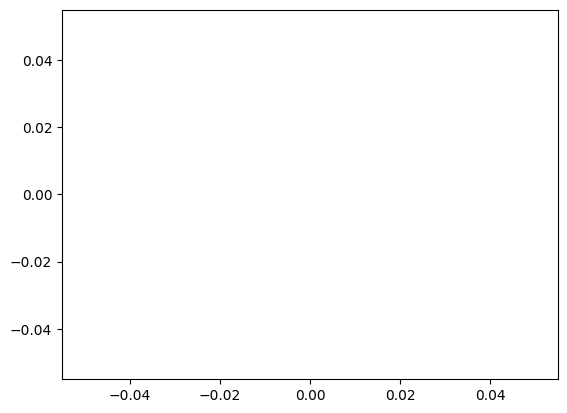

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_values(col):
    # print(sampled[col])
    # sns.histplot(wallets_features_licit[col])
    # sns.histplot(sampled[col])
    fig, ax = plt.subplots(1,1)
    sns.histplot(wallets_features_licit[col].astype(int), stat="probability", ax=ax)
    sns.histplot(sampled[col].astype(int), stat="probability", ax=ax)
    ax.set_xticks(range(1,10))
    plt.show()
    # wallets_features_licit[col].hist(ax=ax)
    # sampled[col].hist(ax=ax)
    
plot_values("num_txs_as_sender")  

<Axes: >

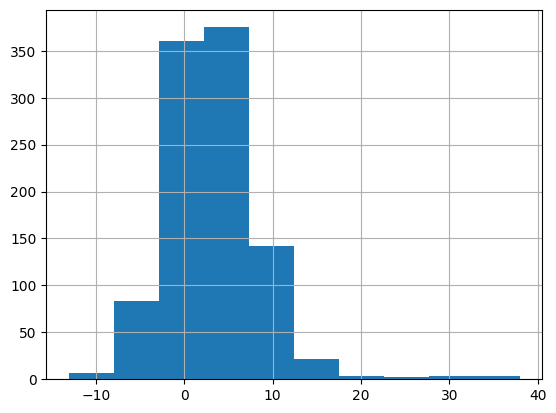

In [43]:
sampled["num_txs_as_sender"].hist()
# wallets_features_licit["num_txs_as_sender"].astype(int).hist()